# Vergleich aller Modelle 
Die Modelle wurden dabei aufgeteilt auf den neu aufbereiteten Datensatz und den im Vorfeld dieser Thesis aufbereiteten Datensatz von sensalytics.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, GRU
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
def get_predictions(y_pred, y_true, indices):
  # Flatten of the predictions, and get the every 10th Value
  # So the window is shortened
  prediction = y_pred.flatten()[0::10]
  true = y_true.flatten()[0::10]
  indices = pd.to_datetime(test_ind.flatten()[0::10])
  dict_plot = {'True': true, 'Pred': prediction}
  return pd.DataFrame(data=dict_plot, index=indices)


def plot_all_predictions(y_pred, y_true, indices):
  df_plot = get_predictions(y_pred, y_true, indices)
  plt.figure(figsize=(10,4))
  plt.title("Vergleich der Vorhersagen:")
  plt.plot(df_plot['True'], linestyle='-', color='#01065a', label='True Values')
  plt.plot(df_plot['Pred'], linestyle='--', color='#e31134', label='Pred Values')
  plt.xlabel('Datum')
  plt.ylabel('Personen im Kassenbereich')
  plt.legend()
  plt.grid(zorder=0)
  plt.gcf().autofmt_xdate()
  dtFmt = mdates.DateFormatter('%d-%m-%y')
  plt.gca().xaxis.set_major_formatter(dtFmt)
  plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator()) 
  plt.xticks(rotation=35)
  plt.show()

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ind = list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix

		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
			ind.append(label.index[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	
	return np.array(X), np.array(y), np.array(ind)

## Neu aufbereitete Daten:

In [ ]:
FILE_NAME = "data_without_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

In [ ]:
dataset = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
dataset.head(5)

,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour
Date_Time,,,,,,,,,
2021-08-12 06:56:00,1,1,0,0,0,8,3,0,6
2021-08-12 06:58:00,0,1,0,2,0,8,3,0,6
2021-08-12 06:59:00,1,1,0,0,0,8,3,0,6
2021-08-12 07:00:00,2,0,1,0,0,8,3,0,7
2021-08-12 07:01:00,3,0,4,0,0,8,3,0,7


In [ ]:
y = dataset.pop('Ø Total Occupancy (Payer)')
display(y.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

### Lineare Regression:
Training und Vorhersage einer linearen Regression.

In [ ]:
linear_new = LinearRegression().fit(train_x, train_y)

In [ ]:
linear_new_pred = linear_new.predict(test_x)
linear_new_pred = linear_new_pred.clip(min=0)

In [ ]:
df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])
df_scores= df_scores.append(pd.Series(calculate_metrics(test_y, linear_new_pred), name='LR:'))
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
LR:,11.029981,3.321141,0.444921,2.535391,2.032612,0.700338


### Vanilla-RNN:

Aufbereitung der Daten für RNN:

In [ ]:
N_INPUT = 180
M_OUTPUT = 10

In [ ]:
train_x, train_y, train_ind = to_supervised(train_x, train_y, N_INPUT, M_OUTPUT)
test_x, test_y, test_ind = to_supervised(test_x, test_y, N_INPUT, M_OUTPUT)

In [ ]:
vanilla_new = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/hyp_model")

In [ ]:
vanilla_new_pred = vanilla_new.predict(test_x)
vanilla_new_pred = vanilla_new_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, vanilla_new_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.179001,3.029687,0.396098,2.307214,1.827991,0.752151
min2:,9.492011,3.080911,0.405049,2.349547,1.852515,0.743729
min3:,9.764342,3.124795,0.415274,2.386053,1.858663,0.736409
min4:,10.017990,3.165121,0.419013,2.415416,1.881204,0.729587
min5:,10.156172,3.186875,0.421316,2.429225,1.876164,0.725882
min6:,10.216494,3.196325,0.432040,2.451171,1.924603,0.724279
min7:,10.331380,3.214246,0.432647,2.462621,1.918737,0.721209
min8:,10.402483,3.225288,0.423931,2.457152,1.909746,0.719324
min9:,10.455167,3.233445,0.430306,2.470699,1.926837,0.717938
min10:,10.602026,3.256075,0.438194,2.496524,1.957089,0.714011


### LSTM-RNN:

In [ ]:
lstm_new = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/new/bay_model")

In [ ]:
lstm_new_pred = lstm_new.predict(test_x)
lstm_new_pred = lstm_new_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, lstm_new_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.207390,3.034368,0.394213,2.291123,1.761476,0.751384
min2:,9.337692,3.055764,0.398986,2.308594,1.780907,0.747895
min3:,9.568500,3.093299,0.406387,2.340795,1.798898,0.741696
min4:,9.748875,3.122319,0.411297,2.367136,1.815536,0.736852
min5:,9.884464,3.143957,0.414573,2.381227,1.822544,0.733216
min6:,9.992119,3.161031,0.412095,2.389455,1.829805,0.730334
min7:,10.052789,3.170613,0.410851,2.394912,1.819496,0.728726
min8:,10.145659,3.185225,0.410819,2.401349,1.824220,0.726254
min9:,10.205140,3.194549,0.412251,2.408839,1.831225,0.724683
min10:,10.198177,3.193458,0.414958,2.413700,1.849630,0.724905


In [ ]:
df_plot_lstm_new = get_predictions(lstm_new_pred, test_y, test_ind)

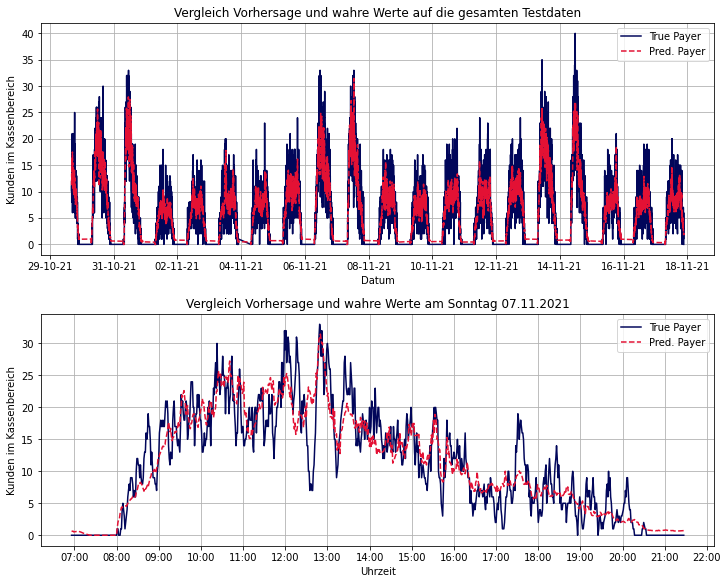

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

ax1.set_title('Vergleich Vorhersage und wahre Werte auf die gesamten Testdaten')
ax1.plot(df_plot_lstm_new['True'], linestyle='-', color='#01065a', label='True Payer')
ax1.plot(df_plot_lstm_new['Pred'], linestyle='--', color='#e31134', label='Pred. Payer')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Kunden im Kassenbereich')
ax1.legend()
ax1.grid(zorder=0)
dtFmt1 = mdates.DateFormatter('%d-%m-%y')
ax1.xaxis.set_major_formatter(dtFmt1)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax2.set_title("Vergleich Vorhersage und wahre Werte am Sonntag 07.11.2021")
ax2.plot(df_plot_lstm_new['2021-11-07':'2021-11-07']['True'], linestyle='-', color='#01065a', label='True Payer')
ax2.plot(df_plot_lstm_new['2021-11-07':'2021-11-07']['Pred'], linestyle='--', color='#e31134', label='Pred. Payer')
ax2.set_xlabel('Uhrzeit')
ax2.set_ylabel('Kunden im Kassenbereich')
ax2.legend()
ax2.grid(zorder=0)
dtFmt2 = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(dtFmt2)
ax2.xaxis.set_major_locator(mdates.HourLocator())

plt.savefig('prediction_lstm.pdf', bbox_inches = 'tight')
plt.show()

### GRU-RNN (ohne Wetterinformationen):

In [ ]:
gru_new = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/bay_model")

In [ ]:
gru_new_pred = gru_new.predict(test_x)
gru_new_pred = gru_new_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, gru_new_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,8.803389,2.967051,0.372933,2.231655,1.756194,0.762293
min2:,9.107935,3.017936,0.380331,2.271927,1.775181,0.754099
min3:,9.392034,3.064643,0.385293,2.304197,1.791379,0.746459
min4:,9.568625,3.093319,0.389920,2.326785,1.805972,0.741717
min5:,9.670645,3.109766,0.393782,2.340376,1.799873,0.738987
min6:,9.731578,3.119548,0.396930,2.351486,1.805183,0.737366
min7:,9.795391,3.129759,0.399897,2.360428,1.819917,0.735672
min8:,9.828335,3.135017,0.401750,2.364671,1.823109,0.734816
min9:,9.884552,3.143971,0.404359,2.372052,1.818688,0.733332
min10:,9.952549,3.154766,0.405618,2.378801,1.827963,0.731531


In [ ]:
df_plot_gru_new = get_predictions(gru_new_pred, test_y, test_ind)

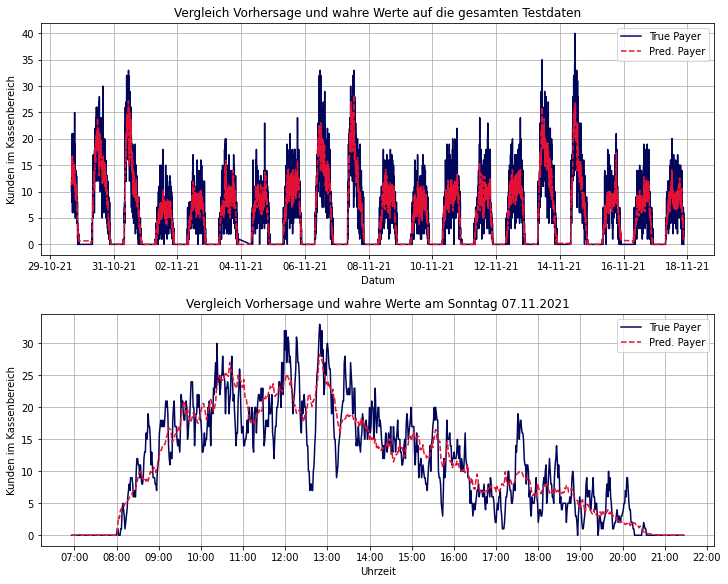

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

ax1.set_title('Vergleich Vorhersage und wahre Werte auf die gesamten Testdaten')
ax1.plot(df_plot_gru_new['True'], linestyle='-', color='#01065a', label='True Payer')
ax1.plot(df_plot_gru_new['Pred'], linestyle='--', color='#e31134', label='Pred. Payer')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Kunden im Kassenbereich')
ax1.legend()
ax1.grid(zorder=0)
dtFmt1 = mdates.DateFormatter('%d-%m-%y')
ax1.xaxis.set_major_formatter(dtFmt1)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax2.set_title("Vergleich Vorhersage und wahre Werte am Sonntag 07.11.2021")
ax2.plot(df_plot_gru_new['2021-11-07':'2021-11-07']['True'], linestyle='-', color='#01065a', label='True Payer')
ax2.plot(df_plot_gru_new['2021-11-07':'2021-11-07']['Pred'], linestyle='--', color='#e31134', label='Pred. Payer')
ax2.set_xlabel('Uhrzeit')
ax2.set_ylabel('Kunden im Kassenbereich')
ax2.legend()
ax2.grid(zorder=0)
dtFmt2 = mdates.DateFormatter('%H:%M')
ax2.xaxis.set_major_formatter(dtFmt2)
ax2.xaxis.set_major_locator(mdates.HourLocator())

plt.savefig('prediction_gru.pdf', bbox_inches = 'tight')
plt.show()

### GRU_RNN (mit Wetterinformationen):

In [ ]:
FILE_NAME = "data_with_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

In [ ]:
dataset_wet = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
dataset_wet.head(5)

,Ø Temperature,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour,cloudy,misty,rainy,stormy,sunny
Date_Time,,,,,,,,,,,,,,,
2021-08-12 06:56:00,22.83,1,1,0,0,0,8,3,0,6,0,0,0,0,1
2021-08-12 06:58:00,22.83,0,1,0,2,0,8,3,0,6,0,0,0,0,1
2021-08-12 06:59:00,22.83,1,1,0,0,0,8,3,0,6,0,0,0,0,1
2021-08-12 07:00:00,22.83,2,0,1,0,0,8,3,0,7,0,0,0,0,1
2021-08-12 07:01:00,22.83,3,0,4,0,0,8,3,0,7,0,0,0,0,1


In [ ]:
y_wet = dataset_wet.pop('Ø Total Occupancy (Payer)')
display(y_wet.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

In [ ]:
train_x_wet, test_x_wet, train_y_wet, test_y_wet = train_test_split(dataset_wet, y_wet, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x_wet, train_y_wet)

train_x_wet = input_scaler.transform(train_x_wet)
test_x_wet = input_scaler.transform(test_x_wet)

In [ ]:
N_INPUT = 180
M_OUTPUT = 10

In [ ]:
train_x_wet, train_y_wet, train_ind_wet = to_supervised(train_x_wet, train_y_wet, N_INPUT, M_OUTPUT)
test_x_wet, test_y_wet, test_ind_wet = to_supervised(test_x_wet, test_y_wet, N_INPUT, M_OUTPUT)

In [ ]:
gru_new_wet = keras.models.load_model('/content/drive/MyDrive/sensalytics/Modelle/GRU-RNN/models/new/hyp_model_wet')

In [ ]:
gru_new_wet_pred = gru_new_wet.predict(test_x_wet)
gru_new_wet_pred = gru_new_wet_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, gru_new_wet_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.045485,3.007571,0.385198,2.269300,1.767255,0.755756
min2:,9.356197,3.058790,0.392093,2.311235,1.806643,0.747396
min3:,9.644267,3.105522,0.397383,2.345302,1.825675,0.739650
min4:,9.842663,3.137302,0.401732,2.371927,1.830470,0.734320
min5:,9.968866,3.157351,0.403609,2.385390,1.836909,0.730938
min6:,10.053519,3.170728,0.406302,2.398886,1.851150,0.728677
min7:,10.113422,3.180161,0.408451,2.407336,1.860726,0.727090
min8:,10.179710,3.190566,0.407693,2.409210,1.850714,0.725335
min9:,10.220394,3.196935,0.408513,2.413454,1.863301,0.724272
min10:,10.283079,3.206724,0.409099,2.418468,1.860051,0.722615


## Im Vorfeld aufbereitete Daten von sensalytics:

In [ ]:
FILE_NAME = "PQM_691.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/tensorflow/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

### Data-Preparation:

In [ ]:
raw_dataset = pd.read_csv(CSV_PATH, header=0, 
                              na_values="?", comment='\t',
                              sep=",", skipinitialspace=False)
dataset = raw_dataset.copy()

Anzeigen des Datasets:

In [ ]:
display(dataset.head(5))

,LOCATION_ID,TRACK_DATETIME_LOCAL,TIME_ID,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
0,691,2021-09-30 10:22:00.000000,102,28,38,71,78,44,28,73,78,33,27,64,69,32,25,58,63,10
1,691,2021-08-28 08:31:00.000000,83,41,46,68,71,39,37,73,77,42,21,60,73,36,33,50,54,12
2,691,2021-09-25 11:14:00.000000,111,62,65,167,175,85,63,165,173,69,66,157,162,70,57,147,158,19
3,691,2021-09-11 07:55:00.000000,75,27,28,50,57,29,15,46,53,27,14,36,44,15,8,28,32,11
4,691,2021-08-19 17:41:00.000000,174,50,37,106,110,51,48,98,101,49,50,98,103,49,61,100,106,11


Die Spalten *LOCATION_ID* und *TIME_ID* werden nicht benötigt und werden deshalb aus dem Dataset entfernt.

In [ ]:
if dataset.get('LOCATION_ID') is not None:
    dataset.pop('LOCATION_ID')
if dataset.get('TIME_ID') is not None:
    dataset.pop('TIME_ID')

Danach wird der Index mit der Spalte *TRACK_DATETIME_LOCAL* ersetzt um den Datensatz nach Datum und Zeit sortieren zu können. Das ist bei Zeitreihen-Daten wichtig, damit eine gewisse Tendenz entstehen kann.

In [ ]:
dataset['TRACK_DATETIME_LOCAL'] = pd.to_datetime(dataset['TRACK_DATETIME_LOCAL'], yearfirst=True)
dataset.set_index('TRACK_DATETIME_LOCAL', inplace=True)
dataset.sort_index(inplace=True)
dataset = dataset.dropna()

In [ ]:
display(dataset.head(5))

,IN_COUNT_LAST_10_MINUTES,OUT_COUNT_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_LAST_10_MINUTES,IN_COUNT_SECOND_LAST_10_MINUTES,OUT_COUNT_SECOND_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_SECOND_LAST_10_MINUTES,IN_COUNT_THIRD_LAST_10_MINUTES,OUT_COUNT_THIRD_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_THIRD_LAST_10_MINUTES,IN_COUNT_FOURTH_LAST_10_MINUTES,OUT_COUNT_FOURTH_LAST_10_MINUTES,AVG_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,MAX_STORE_OCCUPANCY_FOURTH_LAST_10_MINUTES,POS_OCCUPANCY_NEXT_10_MINUTES
TRACK_DATETIME_LOCAL,,,,,,,,,,,,,,,,,
2021-08-12 07:26:00,19,15,15,18,13,7,11,13,14,4,4,10,1,1,0,0,3
2021-08-12 07:28:00,22,17,15,18,14,9,12,15,14,3,5,11,1,2,-1,0,5
2021-08-12 07:29:00,19,19,15,18,16,10,12,17,16,5,6,11,2,3,-1,0,5
2021-08-12 07:40:00,14,16,12,16,16,20,15,18,15,7,13,18,15,4,7,11,2
2021-08-12 07:49:00,17,16,13,17,15,16,12,16,19,19,15,18,16,10,12,17,3


Hier werden die numerischen Spalten des Datasets ermittelt und dann überprüft ob negative Werte vorhanden sind. Da diese bei der Anzahl wie viele Personen den Laden betreten haben oder wie viele sich im Laden befinden, nicht negativ sein können, werden diese auf den Wert **0** gesetzt.

In [ ]:
numerical_headers = dataset.select_dtypes([np.number]).columns
dataset[numerical_headers] = dataset[numerical_headers].clip(lower=0)

Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
y = dataset.pop('POS_OCCUPANCY_NEXT_10_MINUTES')

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

### Lineare Regression:

In [ ]:
linear_old = LinearRegression().fit(train_x, train_y)

In [ ]:
linear_old_pred = linear_old.predict(test_x)
linear_old_pred = linear_old_pred.clip(min=0)

In [ ]:
df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])
df_scores= df_scores.append(pd.Series(calculate_metrics(test_y, linear_old_pred), name='LR:'))
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
LR:,11.108276,3.332908,0.313087,2.612139,2.156633,0.613527


### Vanilla-RNN:


Aufbereitung der Daten für RNN:

In [ ]:
N_INPUT = 180
M_OUTPUT = 10

In [ ]:
train_x, train_y, train_ind = to_supervised(train_x, train_y, N_INPUT, M_OUTPUT)
test_x, test_y, test_ind = to_supervised(test_x, test_y, N_INPUT, M_OUTPUT)

In [ ]:
vanilla_old = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/old/bay_model")

In [ ]:
vanilla_old_pred = vanilla_old.predict(test_x)
vanilla_old_pred = vanilla_old_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, vanilla_old_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,10.465766,3.235084,0.303957,2.533672,2.063647,0.637742
min2:,10.411874,3.226743,0.304532,2.528896,2.057558,0.639691
min3:,10.360124,3.218715,0.303328,2.516911,2.042421,0.641616
min4:,10.358735,3.218499,0.303752,2.515224,2.049871,0.641771
min5:,10.408674,3.226248,0.306752,2.524632,2.073627,0.640179
min6:,10.482049,3.237599,0.310414,2.537574,2.085768,0.637765
min7:,10.574724,3.251880,0.312587,2.550924,2.088306,0.634659
min8:,10.704044,3.271703,0.316395,2.571687,2.121992,0.630316
min9:,10.886067,3.299404,0.321336,2.596257,2.156200,0.624114
min10:,11.007065,3.317690,0.323019,2.609684,2.172700,0.620048


### LSTM-RNN:

In [ ]:
lstm_old = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/old/bay_model")

In [ ]:
lstm_old_pred = lstm_old.predict(test_x)
lstm_old_pred = lstm_old_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, lstm_old_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,10.705248,3.271888,0.306259,2.554986,2.069433,0.629453
min2:,10.601019,3.255921,0.307036,2.546306,2.069113,0.633145
min3:,10.559986,3.249613,0.306216,2.538993,2.058526,0.634703
min4:,10.517316,3.243041,0.307648,2.536857,2.068089,0.636286
min5:,10.526450,3.244449,0.310532,2.542396,2.077706,0.636107
min6:,10.584000,3.253306,0.314041,2.552763,2.105454,0.634242
min7:,10.629614,3.260309,0.315927,2.561042,2.097237,0.632762
min8:,10.737895,3.276873,0.319538,2.576737,2.114925,0.629147
min9:,10.878252,3.298220,0.323043,2.595749,2.126663,0.624384
min10:,11.025770,3.320508,0.326038,2.612009,2.157866,0.619402


### GRU-RNN:

In [ ]:
gru_old = keras.models.load_model("/content/drive/MyDrive/sensalytics/Modelle/LSTM-RNN/models/old/ran_model")

In [ ]:
gru_old_pred = gru_old.predict(test_x)
gru_old_pred = gru_old_pred.clip(min=0)

In [ ]:
df_scores = evaluate_model(test_y, gru_old_pred)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,10.730256,3.275707,0.306600,2.558033,2.103591,0.628587
min2:,10.619263,3.258721,0.309636,2.554086,2.104082,0.632514
min3:,10.598693,3.255563,0.311690,2.552680,2.093846,0.633364
min4:,10.566455,3.250608,0.311321,2.547941,2.079705,0.634587
min5:,10.587319,3.253816,0.309710,2.547380,2.075973,0.634003
min6:,10.711380,3.272824,0.311320,2.562136,2.109357,0.629840
min7:,10.916993,3.304087,0.313371,2.587503,2.130962,0.622834
min8:,10.956034,3.309990,0.316172,2.597944,2.129852,0.621613
min9:,11.100696,3.331771,0.318336,2.616759,2.160689,0.616703
min10:,11.268931,3.356923,0.321515,2.636181,2.177223,0.611009
